# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
import copy
import pylab
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import seaborn as sns

In [2]:
df = pd.read_csv('games.csv')

In [3]:
display(df.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
df = df.rename(columns={'Name': 'name', 'Platform': 'platform', 'Year_of_Release': 'year_of_release', 'Genre': 'genre', 'Other_sales': 'other_sales', 'Critic_Score': 'critic_score', 'User_Score': 'user_score', 'Rating': 'rating'})

In [6]:
display(df.head())

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [7]:
display(df.isna().sum())

name                  2
platform              0
year_of_release     269
genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Можем заметить,что значений 'tbd' в одном из столбцов очень много,если бы мы удалили их,то данные бы сильно исказились.Поэтому,вместо 'tbd' подставим NaN.

In [8]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

In [9]:
display(df.isna().sum())

name                  2
platform              0
year_of_release     269
genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Теперь,когда мы добавили пропуски,начнем менять тип данных.

In [11]:
df['user_score'] = df['user_score'].astype('float64')

In [12]:
df['total'] = df['NA_sales'] + df['EU_sales'] + df['JP_sales'] + df['other_sales']

In [13]:
display(df.head())

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating,total
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


# Исследовательский анализ данных 

<AxesSubplot:>

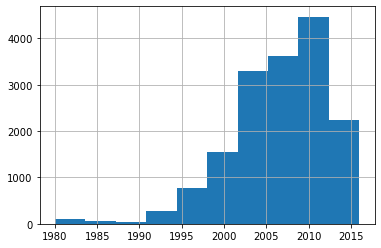

In [14]:
df['year_of_release'].hist()

Данной гистограммой мы увидели сколько игр выпускалось в разные годы.Пик находится в 2008-2012 годах.Такой пик произошел в силу активного развития научно-технического прогресса(далее - НТП).После произошел спад.Возможно,это связано с различного рода кризисами по всему миру.

Судя по гистограмме,игр,выпускаемых с 1980-1990, минимальное количество(в периол с 1980-1990 было выпущено всего 205 игр, при этом на них всего по 2 значения в столбцах critic_score, user_score, rating).Связано это с плохим развитием НТП.В силу того,что данных не так много и они не так важны,избавимся от них.

In [15]:
display(df.query('year_of_release < 1990').count())

name               205
platform           205
year_of_release    205
genre              205
NA_sales           205
EU_sales           205
JP_sales           205
other_sales        205
critic_score         2
user_score           2
rating               2
total              205
dtype: int64

In [16]:
df = df.query('year_of_release >= 1990')

In [17]:
platforms = df.pivot_table(index='platform', aggfunc={'total':'sum'})
display(platforms.sort_values(by=['total'], axis=0, ascending=False).head(10))

,total
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Таким образом мы нашли 10 наиболее популярных платформ.Самой популярной платформой,как оказалось,является PS2 с отрывом в более чем 250 млн продаж.

In [18]:
platforms_years = df.query('year_of_release >= 2013').pivot_table(index='platform', columns='year_of_release',aggfunc={'total':'sum'}).fillna(0)
platforms_years

total                       
year_of_release  2013.0  2014.0  2015.0 2016.0
platform                                      
3DS               56.57   43.76   27.78  15.14
DS                 1.54    0.00    0.00   0.00
PC                12.38   13.28    8.52   5.25
PS3              113.25   47.76   16.82   3.60
PS4               25.99  100.00  118.90  69.25
PSP                3.14    0.24    0.12   0.00
PSV               10.59   11.90    6.25   4.25
Wii                8.59    3.75    1.14   0.18
WiiU              21.65   22.03   16.35   4.60
X360              88.58   34.74   11.96   1.52
XOne              18.96   54.07   60.14  26.15

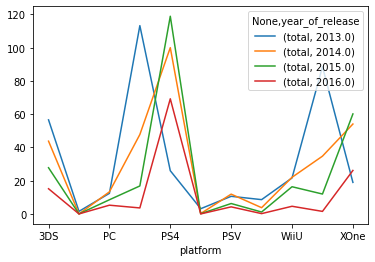

In [19]:
platforms_years.plot(kind='line')
plt.show()

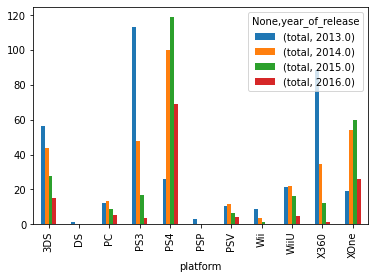

In [20]:
platforms_years.plot(kind='bar')
plt.show()

Данным действием мы построили распределение по годам.Трудно точно сказать как часто появляются новые и исчезают старые платформы,но мне кажется,что новые платформы появляются примерно каждые 3 года.Это заметно на последнем графике.После резкого вплеска происходит резкий спад.Это может происходить из-за появления новых платформ

Актуальным периодом будем считать данные с 2013 по 2016 год.

В силу того,что линейный график для меня не совсем нагляден,я решил построить еще один график

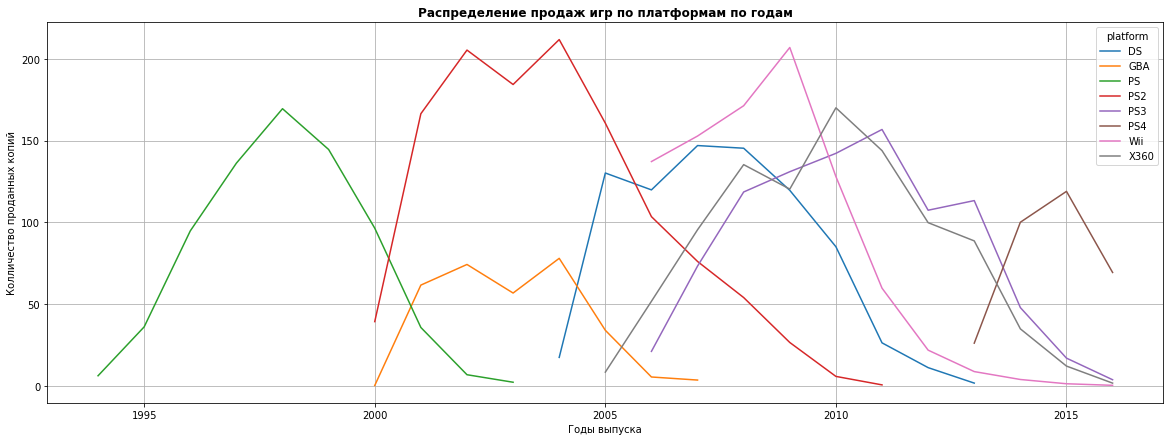

In [21]:
test_top = (df.pivot_table(index = 'platform', values = 'total', aggfunc = 'sum').reset_index()
                .sort_values(by = 'total', ascending = False).head(8))['platform']

(df
    .query('platform in @test_top and year_of_release > 1990')
    .pivot_table(index=['year_of_release'], columns='platform', values=['total'], aggfunc='sum')
    .reset_index()
    .plot(x='year_of_release', y='total', kind='line', grid=True, figsize=(20, 7))
)

plt.title('Распределение продаж игр по платформам по годам', fontweight="bold")
plt.xlabel('Годы выпуска')
plt.ylabel('Колличество проданных копий')
plt.show()

In [22]:
platforms_from_actual_time = df.query('year_of_release >= 2013').pivot_table(index='platform', aggfunc={'total':'sum'})
display(platforms_from_actual_time.sort_values(by=['total'], axis=0, ascending=False).head(10))

,total
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


Можем заметить,что Х360,который был 2 по продажам,когда мы анализировали данные полностью,на данный момент шестой,среди данных на 2013-2016,а PS2,который был первым,сейчас вовсе отсутствует в рейтинге.Это может обозначать только то,что старые платформы отходят на задний план и пришло время новых платформ.

In [23]:
platforms_years_from_actual_time = df.query('year_of_release >= 2013').pivot_table(index='platform', columns='year_of_release',aggfunc={'total':'sum'}).fillna(0)
platforms_years_from_actual_time

total                       
year_of_release  2013.0  2014.0  2015.0 2016.0
platform                                      
3DS               56.57   43.76   27.78  15.14
DS                 1.54    0.00    0.00   0.00
PC                12.38   13.28    8.52   5.25
PS3              113.25   47.76   16.82   3.60
PS4               25.99  100.00  118.90  69.25
PSP                3.14    0.24    0.12   0.00
PSV               10.59   11.90    6.25   4.25
Wii                8.59    3.75    1.14   0.18
WiiU              21.65   22.03   16.35   4.60
X360              88.58   34.74   11.96   1.52
XOne              18.96   54.07   60.14  26.15

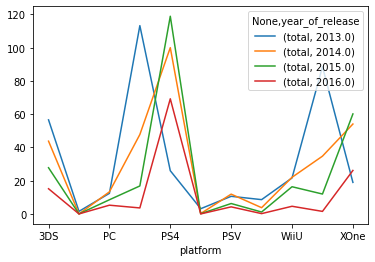

In [24]:
platforms_years_from_actual_time.plot(kind='line')
plt.show()

Из полученных данных можно сделать небольшой вывод.Такие платформы как 3DS,DS,PC,PS3,PSP,PSV,Wii,WiiU,X360 теряли в продажах.Кто-то терял десятки миллионов продаж,кто-то меньше.А другие только прибавляли кол-во продаж - это значит,что платформы являются новые и актуальными на сегодняшнем рынке игр.

Особо прибыльными платформами являются PS4 и XOne

Самыми продаваемыеми платформами в 2016 году являются PS4, XOne.

Теперь построим ящик с усами.

<AxesSubplot:>

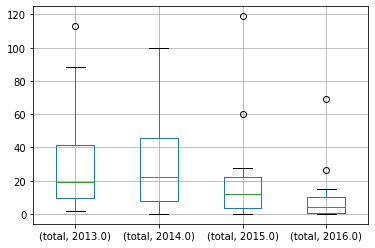

In [25]:
display(platforms_years_from_actual_time.boxplot())

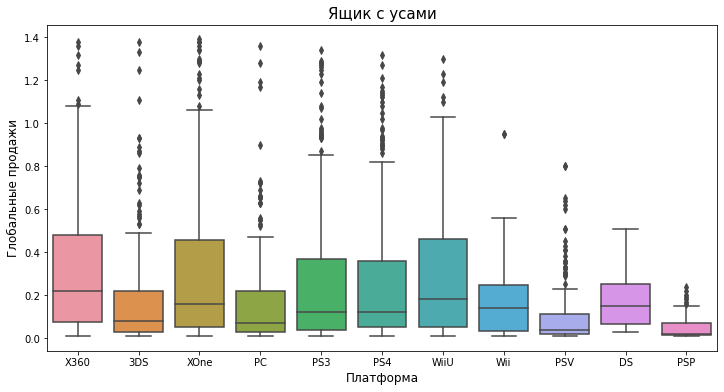

In [26]:
plt.figure(figsize=(12,6))

sns.boxplot(data=df[(df['year_of_release']>=2013) & (df['total']<=1.4)], x='platform', y='total')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12);

In [27]:
df

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating,total
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


In [28]:
platforms_years_from_actual_time.describe()

total                                   
year_of_release      2013.0      2014.0      2015.0     2016.0
count             11.000000   11.000000   11.000000  11.000000
mean              32.840000   30.139091   24.361818  11.812727
std               37.234578   30.251916   35.782009  20.629461
min                1.540000    0.000000    0.000000   0.000000
25%                9.590000    7.825000    3.695000   0.850000
50%               18.960000   22.030000   11.960000   4.250000
75%               41.280000   45.760000   22.300000  10.195000
max              113.250000  100.000000  118.900000  69.250000

## Мини-вывод:
Среднее значение с 2013-2016 уменьшалось и уменьшалось.
Дисперсия и среднее отклонение были нестабильны.В один год значения возрастают,в другой падают.
Минимальное значение на всем промежутке не равнялось 2.
Медианное значение в промежутке с 2014 года уменьшалось, с каждым годом все больше и больше.
Значение третьего квартиля было максимальным в 2014.Минимальным в 2016.
Максимальное значение было в 2015 году.Самое маленькое значение - 2016 год.

Из этого можно сделать вывод,что 2016 год был провальным в сфере игр.

<AxesSubplot:xlabel='total', ylabel='user_score'>

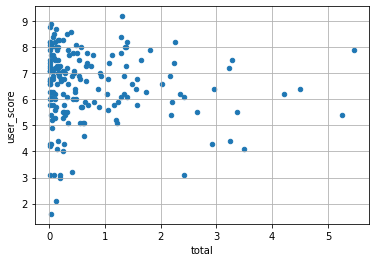

In [29]:
df.query('(platform == "XOne") & (year_of_release >= 2013)').plot(x='total', y='user_score', kind='scatter', grid=True)

In [30]:
display(df.query('(platform == "XOne") & (year_of_release >= 2013)')['user_score'].corr(df.query('(platform == "XOne") & (year_of_release >= 2013)')['total']))

-0.06892505328279418

<AxesSubplot:xlabel='total', ylabel='critic_score'>

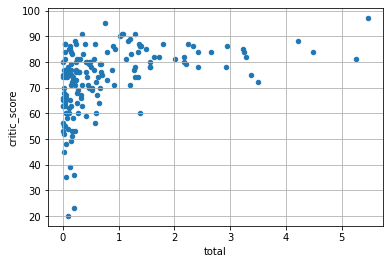

In [31]:
df.query('(platform == "XOne") & (year_of_release >= 2013)').plot(x='total', y='critic_score', kind='scatter', grid=True)

In [32]:
display(df.query('(platform == "XOne") & (year_of_release >= 2013)')['critic_score'].corr(df.query('(platform == "XOne") & (year_of_release >= 2013)')['total']))

0.41699832800840153

<AxesSubplot:xlabel='total', ylabel='user_score'>

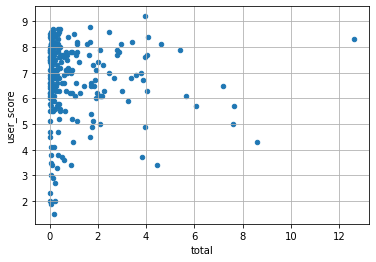

In [33]:
df.query('(platform == "PS4") & (year_of_release >= 2013)').plot(x='total', y='user_score', kind='scatter', grid=True)

In [34]:
display(df.query('(platform == "PS4") & (year_of_release >= 2013)')['user_score'].corr(df.query('(platform == "PS4") & (year_of_release >= 2013)')['total']))

-0.03195711020455644

<AxesSubplot:xlabel='total', ylabel='critic_score'>

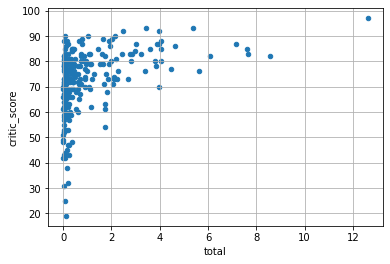

In [35]:
df.query('(platform == "PS4") & (year_of_release >= 2013)').plot(x='total', y='critic_score', kind='scatter', grid=True)

In [36]:
display(df.query('(platform == "PS4") & (year_of_release >= 2013)')['critic_score'].corr(df.query('(platform == "PS4") & (year_of_release >= 2013)')['total']))

0.40656790206178123

## Мини-вывод
Этими действиями я просмотрел корреляцию между общими продажами платформ PS4 и XOne и оценками критиков и пользователей.Рассмотрим каждую платформу по отдельности.

PS4: корреляция между оценками пользователей и продажей игр на платформе PS4 отрицательная и равна -0,031.Немного.Корреляция между оценками критиков и продажей игр положительная и равна 0,4.Это значит,что оценки критиков обладают бОльшим влиянием на продажи,чем оценки пользователей

XOne: корреляция между общими продажами и оценками пользователей -0,068, корреляция между общими продажами и оценками критиков - 0,41.Ситуация аналогичная,как и с PS4.

In [37]:
popular_genres = df.query('year_of_release >= 2006').pivot_table(index='genre', aggfunc={'total':'median'})
display(popular_genres.sort_values(by=['total'], axis=0, ascending=False))

,total
genre,
Shooter,0.290
Platform,0.225
Sports,0.200
Racing,0.170
Action,0.160
Fighting,0.160
Role-Playing,0.150
Misc,0.130
Simulation,0.130


Данной пивот таблицей мы увидели ситуацию по общим продажам игр разных жанров.Самым популярным жанром является Shooter.Самым непопулярным Adventure.Их можно и назвать самым прибыльным,и самым неприбыльным жанрами.Разница между ними коллосальная(они различаются в 7.25 раз).

# Портрет пользователя каждого региона

In [38]:
for region in df.loc[:, 'NA_sales': 'other_sales']:
    platforms_region = df.query('year_of_release >= 2013').pivot_table(index='platform' , values=region , aggfunc='sum')
    display(platforms_region.sort_values(by= region , axis=0, ascending=False).head())

,NA_sales
platform,
PS4,108.74
XOne,93.12
X360,81.66
PS3,63.50
3DS,38.20


,EU_sales
platform,
PS4,141.09
PS3,67.81
XOne,51.59
X360,42.52
3DS,30.96


,JP_sales
platform,
3DS,67.81
PS3,23.35
PSV,18.59
PS4,15.96
WiiU,10.88


,other_sales
platform,
PS4,48.35
PS3,26.77
XOne,14.27
X360,12.11
3DS,6.28


Рассмотрим разные регионы:

Северная Америка: самой популярной платформой,считая от 2013 года, является PS4.На данную платформу приходится 108 млн продаж.После PS4 идет платформа XOne.У нее 93 млн продаж.

Европа: самой популярной плаформой в Европе с 2013 года является PS4.У данной платформы 141 млн продаж.После PS4 идет PS3.У данной платформы ~68 млн продаж.

Япония: самой популярной платформой в Японии является 3DS.У нее ~68 млн продаж.Чуть меньше у PS3 - 23 млн.

Другие страны: самой популярной платформой в других странах является PS4.У нее 48 млн продаж.Потом идет PS3 - ~27 млн продаж.

Итого: продажи в разных регионах сильно различаются.Больше всего игр покупают в Северной Америке.Меньше всего - в других странах.Связано это может быть с финансовыми положениями в разных регионах.Вероятнее всего, в Северной Америке люди,в силу своих финансовых возможностей,могут позволить себе больше покупать различных платформ.В других странах ситуация полностью наоборот.Самыми популярными платформами можно назвать PS4 и PS3.Они чаще всех попадаются в списках топ-5.Часто занимают позиции выше 3 места.

,NA_sales
genre,
Shooter,0.200
Platform,0.090
Sports,0.080
Fighting,0.045
Racing,0.030


array([[<AxesSubplot:title={'center':'NA_sales'}>]], dtype=object)

,EU_sales
genre,
Shooter,0.190
Platform,0.080
Racing,0.060
Sports,0.050
Simulation,0.035


array([[<AxesSubplot:title={'center':'EU_sales'}>]], dtype=object)

,JP_sales
genre,
Role-Playing,0.05
Fighting,0.03
Misc,0.02
Puzzle,0.02
Action,0.01


array([[<AxesSubplot:title={'center':'JP_sales'}>]], dtype=object)

,other_sales
genre,
Shooter,0.050
Platform,0.025
Sports,0.020
Action,0.010
Fighting,0.010


array([[<AxesSubplot:title={'center':'other_sales'}>]], dtype=object)

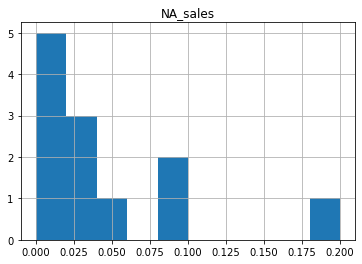

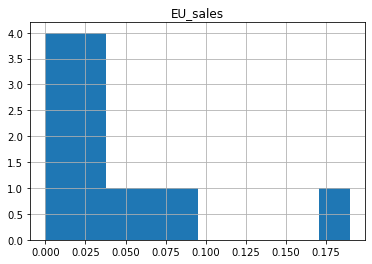

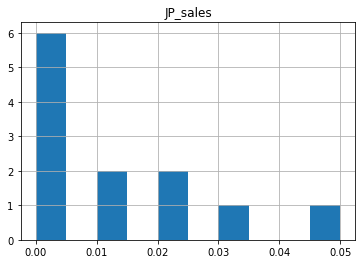

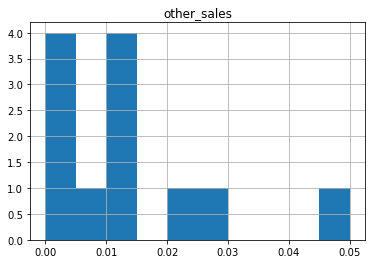

In [39]:
for region in df.loc[:, 'NA_sales': 'other_sales']:
    genres_region = df.query('year_of_release >= 2013').pivot_table(index='genre' , values=region , aggfunc='median')
    display(genres_region.sort_values(by= region , axis=0, ascending=False).head())
    display(genres_region.sort_values(by= region , axis=0, ascending=False).hist())

Рассмотрим разные регионы:

Северная Америка: самым популярным жанром в Северной Америке является Shooter.

Европа: самым популярным жанром в Европе также является Shooter,но в Европе уже показатели ниже.

Япония: самым популярным жанром в Японии является Role-Playing.

Другие страны: самым популярным жанром в других странах является вновь Shooter.Но показатели в данном регионе намного ниже,чем были в Европе и Северной Америке.

Итого: самым популярным жанром во всех регионах можно назвать Shooter.Именно игр с данным жанром продается больше всего.Также популярными жанрами являются: Role-Playing,Shooters,Sports.

In [40]:
df.loc[df['rating'].isna(), 'rating'] = 'tbd' 

,NA_sales
rating,
M,165.21
tbd,89.42
E,79.05
E10+,54.24
T,49.79


array([[<AxesSubplot:title={'center':'NA_sales'}>]], dtype=object)

,EU_sales
rating,
M,145.32
E,83.36
tbd,78.91
E10+,42.69
T,41.95


array([[<AxesSubplot:title={'center':'EU_sales'}>]], dtype=object)

,JP_sales
rating,
tbd,85.05
T,20.59
E,15.14
M,14.11
E10+,5.89


array([[<AxesSubplot:title={'center':'JP_sales'}>]], dtype=object)

,other_sales
rating,
M,47.04
tbd,23.46
E,22.61
T,14.29
E10+,12.57


array([[<AxesSubplot:title={'center':'other_sales'}>]], dtype=object)

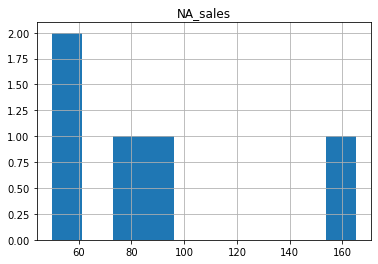

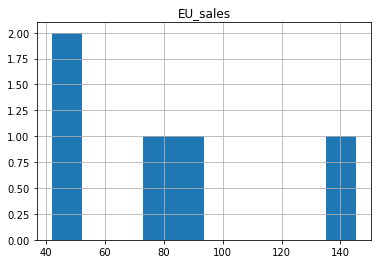

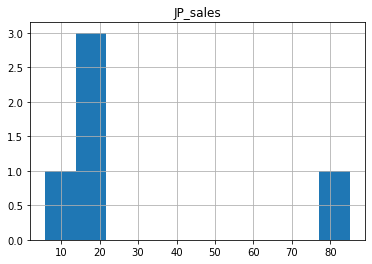

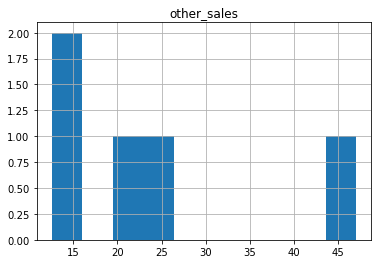

In [41]:
for region in df.loc[:, 'NA_sales': 'other_sales']:
    marks_region = df.query('year_of_release >= 2013').pivot_table(index='rating' , values=region , aggfunc='sum')
    display(marks_region.sort_values(by= region , axis=0, ascending=False).head())
    display(marks_region.sort_values(by= region , axis=0, ascending=False).hist())

Ситуация на всех рынках одна и та же.Самой популярной оценкой является М.

# Проверка гипотез

In [42]:
df.head()

,name,platform,year_of_release,genre,NA_sales,EU_sales,JP_sales,other_sales,critic_score,user_score,rating,total
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,tbd,31.38
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80


In [43]:
xone = []
pc = []
xone = df.query('(year_of_release >= 2013) & (platform == "XOne")')['user_score'].dropna()
pc = df.query('(year_of_release >= 2013) & (platform == "PC")')['user_score'].dropna()

In [44]:
alpha = .01
results = st.ttest_ind(
    xone, 
    pc)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


In [45]:
alpha = .01
results = st.ttest_ind(
    df.query('(year_of_release >= 2013) & (platform == "XOne")')['user_score'].dropna(), 
    df.query('(year_of_release >= 2013) & (platform == "PC")')['user_score'].dropna())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу,а значит,что средние пользовательские рейтинги платформ XboxOne и PC одинаковые.

Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.Тип у данной гипотезы,как я ее сформулировал,будет двусторонний,т.е нулевая гипотеза - cредние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые; альтернативная гипотеза - средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [46]:
action = []
sports = []
action = df.query('(year_of_release >= 2013) & (genre == "Action")')['user_score'].dropna()
sports = df.query('(year_of_release >= 2013) & (genre == "Sports")')['user_score'].dropna()

In [47]:
alpha = .01
results = st.ttest_ind(
    action, 
    sports)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


Мы отвергли нулевую гипотезу,а значит,средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») действительно разные.

# Вывод

Нам необходимо было выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.Из анализа мы поняли,что лучше всего продаются игры на таких платформах как: PS4, XONE.Жанр у данной игры должен быть либо Shooter(пользуется наибольшим спросом), либо Sports, либо Role-Playing.Лучше всего выпускать и чаще показывать рекламу в Северной Америке,так как там продается наибольшее количество игр в миллионах продаж.Наименьший акцент можно сделать на другие страны,так как там продается наименьшее количество игр.Оценка у данной игры должна быть M.